# Efficient supply allocation problem
Author: inga-ii

Date: 7th March 2024

### Objective
Given a two-sided marketplace (a ride-hailing platform), the goal is to address the problem of real-time supply allocation (drivers) in a way that efficiently meets the demand for rides. Matching supply with demand benefits both sides of the market: riders can secure rides with potentially reduced waiting times, while drivers can achieve more stable earnings.

### Data
The dataset contains approximately 627,000 rows of data from March 2022, representing ride requests in Tallinn, Estonia. Each row provides the following information about a ride:
- `start_time` - The time when the order was placed.
- `start_lat` and `start_lng` - The coordinates of the pickup point.
- `end_lat` and `end_lng` - The coordinates of the destination point.
- `ride_value` - The monetary value of the order.

However, the dataset lacks information on several aspects:
- The waiting time before a ride was accepted.
- Confirmation that a ride actually occurred.
- The supply levels at the time of the request (e.g., how many drivers were within a reasonable proximity to the pickup point, and their availability status).
- Details on how prices were dynamically adjusted in response to demand and supply fluctuations, if at all.
- The company's general strategy regarding request prioritization, such as which requests are considered more important, if specific locations should be prioritized due to strategic importance, etc.
- Insights into what is more valuable to the company and drivers: long or short rides, rides within the city versus longer journeys, and the economics of longer rides ending outside high-demand areas.

### Assumptions
I will start with an assumption.

I assume that the price per unit of distance remains constant. This implies that the demand for rides is not influenced by the price per kilometer but is instead determined by external factors beyond the company's control. An examination of the data reveals only minor variations in price per kilometer, supporting the assumption of a fixed price. Although in real-life, it's likely that ride prices are dynamically adjusted to balance increases in demand or decreases in supply.


### Proposal

To tackle the problem outlined in the assignment, I propose the creation of a smart recommendation system that guides drivers to *optimal* locations. I see this system as being capable of reallocating supply in real-time by directing drivers to areas where demand either exceeds or is anticipated to exceed supply. In an ideal scenario, this system would:
- Understand the nature of the demand side, accurately forecast demand by neighborhood/district for the near future (for the next 30/60/90/... minutes) and, to a reasonable extent, for the next day.
- Consider more than just the immediate step by taking into account not only the current unmatched demand but also the forecasted demand at the destination point, the next destination point, and so on, when recommending rides.
- Recommend to drivers in real-time which rides to accept or which areas to move to, optimizing the experience for both drivers and passengers.
- Provide drivers with high-level insights about the forecasted demand for the next day or days.


### Solution

In this notebook I will focus on exploring a simple demand forecasting solution that can later serve as a foundation for the recommendation system. 
To enable the system to function in its most basic form, it will be sufficient to accurately predict the demand for rides per neighborhood for different times of the day.
These predictions could be communicated to drivers through messages in their ride-hailing app, possibly in the form of: "You are currently in an area where we predict low demand in the next 90 minutes. Consider moving to area X, Y, or Z, where we expect higher demand soon."
Although this initial system will be somewhat short-sighted (greedy), it has the potential to improve supply allocation.


### Notebook structure
The notebook consists of the following parts:
- Data Exploration.
- Data Cleaning.
- Splitting the Problem into Smaller Problems and Feature Engineering.
- Modeling.
- Real-world Validation Strategy.
- Next Steps.

# Data Exploration and Cleaning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h3
import math
import folium
import geopandas as gpd
from geodatasets import get_path
from itertools import product
from datetime import datetime
import lightgbm
import numpy as np
from sklearn.cluster import KMeans
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import holidays

In [2]:
df = pd.read_csv('robotex5.csv')

In [3]:
df.sample(3)

start_time  start_lat  start_lng    end_lat  \
499481  2022-03-13 08:41:52.688429000  59.439162  24.715680  59.438809   
55000   2022-03-12 23:35:18.432725000  59.440628  24.733621  59.439532   
55883   2022-03-19 13:29:58.974205000  59.437007  24.750267  59.434112   

          end_lng  ride_value  
499481  24.849117     1.85125  
55000   24.737464     0.12500  
55883   24.760361     0.16125

In [4]:
df.dtypes

start_time     object
start_lat     float64
start_lng     float64
end_lat       float64
end_lng       float64
ride_value    float64
dtype: object

In [5]:
# Check for missing values
df.isnull().sum()

start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
dtype: int64

In [6]:
df.shape

(627210, 6)

Create time-based features which might be helpful in data exploration and later in modeling. 

In [7]:
# Create features from start_time

df['start_time'] = pd.to_datetime(df['start_time'])

df['start_date'] = df['start_time'].dt.date
df['start_date2'] = pd.to_datetime(df['start_date'])

df['start_day'] = df['start_time'].dt.day_name()
df['start_day_of_week'] = df['start_time'].dt.day_of_week # Monday=0, Sunday=6
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df['start_hour'] = df['start_time'].dt.hour
df['start_minute'] = df['start_time'].dt.minute

df['start_unit_h'] = df['start_hour'].astype(str).str.zfill(2) + pd.cut(df['start_minute'], bins=[0, 30, 60], labels=['H00', 'H30'], include_lowest=True).astype(str)
df['start_unit_q'] = df['start_hour'].astype(str).str.zfill(2) + pd.cut(df['start_minute'], bins=[0, 15, 30, 45, 60], labels=['Q00', 'Q15', 'Q30', 'Q45'], include_lowest=True).astype(str)

df['start_unit_2t'] = pd.cut(df['start_hour'], bins=range(0, 25, 2), include_lowest=True, labels=['{}T2'.format(i) for i in range(0, 24, 2)], right=False).astype(str).str.zfill(4)
df['start_unit_4t'] = pd.cut(df['start_hour'], bins=range(0, 25, 4), include_lowest=True, labels=['{}T4'.format(i) for i in range(0, 24, 4)], right=False).astype(str).str.zfill(4)


df['start_time_int60m'] = df['start_time'].dt.floor('60min')
df['start_time_int30m'] = df['start_time'].dt.floor('30min')

In [8]:
# Check the timeframe of the data
print(f"min date: {df['start_date'].min()}, max date: {df['start_date'].max()}")
print("unique dates:", df['start_date'].nunique())

min date: 2022-03-01, max date: 2022-03-28
unique dates: 28


The dataset contains data from March 1st, 2022 to March 28th, 2022 (4 weeks). Each date in between the start and end dates is present.

In [9]:
# Check for bank holidays - they would most likely affect demand for rides.

estonia_holidays = holidays.Estonia(years=2022)
estonia_holidays
for key, value in estonia_holidays.items():
    print(f"{key}: {value}")

# Check if March 2022 had public holidays
start_date = pd.to_datetime('2022-03-01')
end_date = pd.to_datetime('2022-03-31')
dates = pd.date_range(start_date, end_date)

public_holidays = [date for date in dates if date in estonia_holidays]
print(f'Holidays in March 2022: {public_holidays}')


2022-01-01: uusaasta
2022-02-24: iseseisvuspäev
2022-04-15: suur reede
2022-04-17: ülestõusmispühade 1. püha
2022-05-01: kevadpüha
2022-06-05: nelipühade 1. püha
2022-06-23: võidupüha
2022-06-24: jaanipäev
2022-08-20: taasiseseisvumispäev
2022-12-24: jõululaupäev
2022-12-25: esimene jõulupüha
2022-12-26: teine jõulupüha
Holidays in March 2022: []


There were no public holidays in Estonia in March 2022.

### Outliers

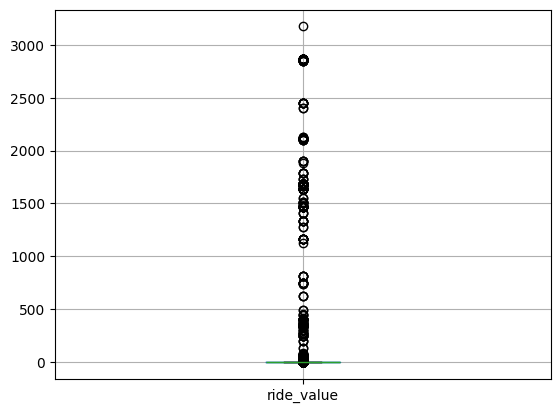

In [10]:
df.boxplot(column=['ride_value'])
plt.show()

There are rows which have unexpectedly high `ride_value`. Some of them, due to their extreme values, could even be data collection issues.

I will keep all observations yet, will check other features now.

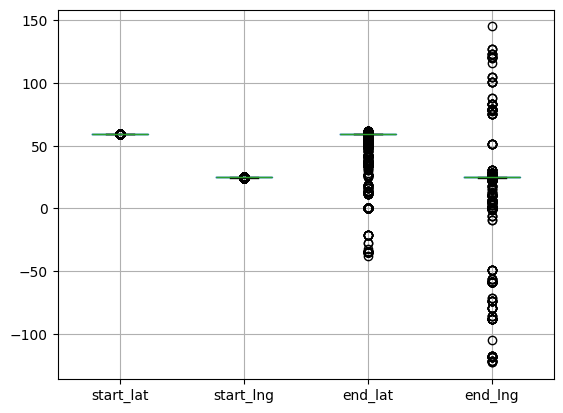

In [11]:

df.boxplot(column=['start_lat', 'start_lng', 'end_lat', 'end_lng'])
plt.show()


There are clearly outliers in the `end_lat` and `end_lng` columns, especially `end_lng`. The data is expected to come from Tallin, Estonia, but clearly not all coordinates in the dataset are located in Estonia or even Europe. 

Also, the end coordinates are more heavily affected by the outliers than the start coordinates.

Let's have a look at some rows having unexpected coordinates.

In [12]:
df[df['end_lng'] > 120]

start_time  start_lat  start_lng    end_lat  \
181768 2022-03-08 17:16:05.839000  59.397229  24.644015  16.416333   
191987 2022-03-22 00:43:30.985685  59.436629  24.751962 -37.819979   
271640 2022-03-20 07:37:45.254579  59.401552  24.717377  45.778636   
276133 2022-03-05 07:37:45.254579  59.401552  24.717377  45.778636   
336910 2022-03-06 16:57:54.853403  59.431626  24.713391  16.416132   
361816 2022-03-07 16:00:47.395618  59.418679  24.805310  11.599461   
385014 2022-03-27 16:00:46.296000  59.418715  24.805337  11.599489   
425892 2022-03-14 16:00:50.269000  59.418694  24.805261  11.599434   
454204 2022-03-26 07:37:45.254579  59.401552  24.717377  45.778636   
472481 2022-03-04 16:00:47.395618  59.418679  24.805310  11.599461   
501567 2022-03-27 10:53:18.374215  59.436375  24.776510  30.236684   
501874 2022-03-14 16:57:54.853403  59.431626  24.713391  16.416132   
544048 2022-03-26 14:49:02.983720  59.432598  24.776812  16.416331   
574647 2022-03-17 14:49:02.983720  59.432598  24.776812  16.416331   
613922 2022-03-22 14:51:16.246546  59.360215  24.631996  30.236538   

           end_lng   ride_value  start_date start_date2 start_day  \
181768  120.596859  1787.469028  2022-03-08  2022-03-08   Tuesday   
191987  144.966110  3172.701000  2022-03-22  2022-03-22   Tuesday   
271640  126.638681  1463.814750  2022-03-20  2022-03-20    Sunday   
276133  126.638681  1463.814750  2022-03-05  2022-03-05  Saturday   
336910  120.597367  1787.403000  2022-03-06  2022-03-06    Sunday   
361816  122.743649  1899.336250  2022-03-07  2022-03-07    Monday   
385014  122.743674  1899.342924  2022-03-27  2022-03-27    Sunday   
425892  122.743674  1899.346005  2022-03-14  2022-03-14    Monday   
454204  126.638681  1463.814750  2022-03-26  2022-03-26  Saturday   
472481  122.743649  1899.336250  2022-03-04  2022-03-04    Friday   
501567  120.158452  1551.781000  2022-03-27  2022-03-27    Sunday   
501874  120.597367  1787.403000  2022-03-14  2022-03-14    Monday   
544048  120.596829  1786.756750  2022-03-26  2022-03-26  Saturday   
574647  120.596829  1786.756750  2022-03-17  2022-03-17  Thursday   
613922  120.158675  1552.394750  2022-03-22  2022-03-22   Tuesday   

        start_day_of_week  start_hour  start_minute start_unit_h start_unit_q  \
181768                  1          17            16        17H00        17Q15   
191987                  1           0            43        00H30        00Q30   
271640                  6           7            37        07H30        07Q30   
276133                  5           7            37        07H30        07Q30   
336910                  6          16            57        16H30        16Q45   
361816                  0          16             0        16H00        16Q00   
385014                  6          16             0        16H00        16Q00   
425892                  0          16             0        16H00        16Q00   
454204                  5           7            37        07H30        07Q30   
472481                  4          16             0        16H00        16Q00   
501567                  6          10            53        10H30        10Q45   
501874                  0          16            57        16H30        16Q45   
544048                  5          14            49        14H30        14Q45   
574647                  3          14            49        14H30        14Q45   
613922                  1          14            51        14H30        14Q45   

       start_unit_2t start_unit_4t   start_time_int60m   start_time_int30m  
181768          16T2          16T4 2022-03-08 17:00:00 2022-03-08 17:00:00  
191987          00T2          00T4 2022-03-22 00:00:00 2022-03-22 00:30:00  
271640          06T2          04T4 2022-03-20 07:00:00 2022-03-20 07:30:00  
276133          06T2          04T4 2022-03-05 07:00:00 2022-03-05 07:30:00  
336910          16T2          16T4 2022-03-06 16:00:00 2022-03-06 16:30:00  
361816          16T2          16T4 202

Interestingly, `ride_value` is proportional to the large distance between the start and end location.

In [13]:
# Check if a set of stard and end coordinates are in Estonia (approx. method)

estonia_lat_min = 57.2
estonia_lat_max = 59.5
estonia_lng_min = 21.5
estonia_lng_max = 28.1

df['is_estonia'] = (df['start_lat'] > estonia_lat_min) & (df['start_lat'] < estonia_lat_max) & (df['start_lng'] > estonia_lng_min) & (df['start_lng'] < estonia_lng_max) & (df['end_lat'] > estonia_lat_min) & (df['end_lat'] < estonia_lat_max) & (df['end_lng'] > estonia_lng_min) & (df['end_lng'] < estonia_lng_max)
df.groupby('is_estonia').size()

is_estonia
False     18167
True     609043
dtype: int64

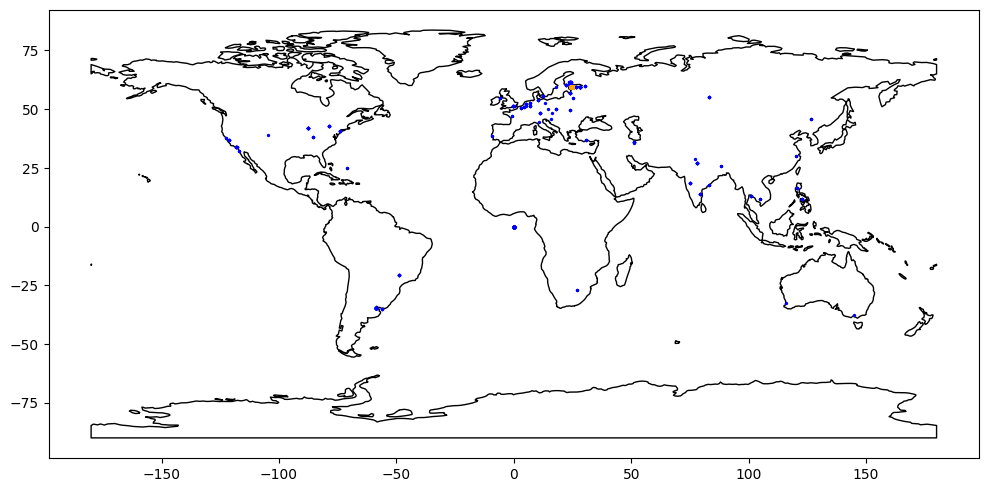

In [14]:
# Plot coordinates of trips starting or ending outside Estonia

df0 = df[df['is_estonia'] == False]

gdf0 = gpd.GeoDataFrame(df0, geometry=gpd.points_from_xy(df0['start_lng'], df0['start_lat']))
gdf1 = gpd.GeoDataFrame(df0, geometry=gpd.points_from_xy(df0['end_lng'], df0['end_lat']))

world_map = gpd.read_file(get_path("naturalearth.land"))

fig, ax = plt.subplots(figsize=(12, 8))
world_map.plot(ax=ax, color='white', edgecolor='black')

gdf1.plot(ax=ax, markersize=2, color='blue')
gdf0.plot(ax=ax, markersize=6, color='orange')

plt.show()

It is clear that some of the locations cannot be correct drop-off locations for rides in Tallinn. I will proceed with deleting all trips that start or end outside Estonia.

In [15]:
# Drop the rows where is_estonia is False
df = df[df['is_estonia'] == True]

### Pickup and Dropoff Locations

Now, let's have a closer look at the topography of Tallinn.

I'll plot a sample of coordinates to grasp an understanding of where rides start or end and what natural barriers should be considered while planning routes.

In [16]:
# Plot a more detailed map, focusing on Tallinn
df0 = df.sample(1000)

map_center = [59.407910, 24.689836]
m = folium.Map(location=map_center, zoom_start=12)
for index, row in df0.iterrows():
    lat = row['start_lat']
    lon = row['start_lng']
    folium.Marker([lat, lon]).add_to(m)
m


We can see on the map that indeed, existence of big natural water bodies heavily impacts the shortest driving path between locations. 

As a result, when considering the distance between two locations, it's more accurate to think in terms of road distance. Other approximate measures, such as Euclidean, Haversine, or Manhattan distance, will tend to underrepresent the true distance that a car must traverse.

That being said, for the purposes of this notebook, to maintain simplicity, I will refrain from calculating the road distance between locations. (Anyway, in this demand forecasting baseline, length of the ride is not taken into account.)

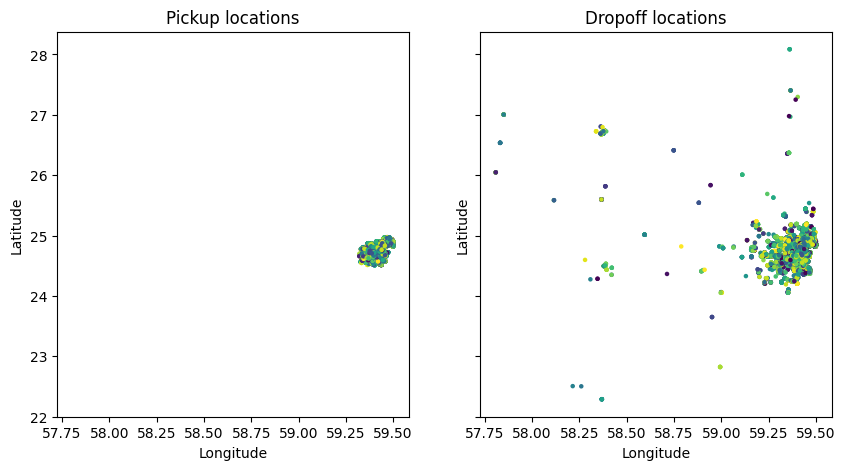

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)

scatter1 = ax[0].scatter(x=df.start_lat.values, y=df.start_lng.values, c=df.start_hour, s=5, cmap='viridis')
scatter2 = ax[1].scatter(x=df.end_lat.values, y=df.end_lng.values, c=df.start_hour, s=5, cmap='viridis')

ax[0].set_title("Pickup locations")
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[1].set_title("Dropoff locations")
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()

Pickup and dropoff locations are not uniformly distributed across the city. Pickup locations are more concentrated in the city center, while dropoff locations are more spread out.

### Distance

I want to have a closer look at the distances travelled within Estonia.

In [18]:
# Create a function that will calculate the shortest distance between two sets of coordinates

def calculate_haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Radius of the Earth in kilometers
    radius = 6371

    # Calculate the differences between the latitudes and longitudes
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Calculate the Haversine formula
    a = math.sin(delta_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

In [19]:
df['distance_h'] = df.apply(lambda row: calculate_haversine_distance(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']), axis=1)

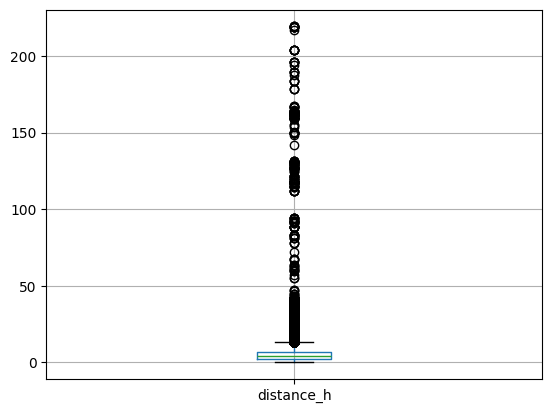

In [20]:
df.boxplot(column=['distance_h'])
plt.show()

In [21]:
# Plot a map with trips > 50 km (by the shortest distance, not the road distance)

df0 = df[df['distance_h'] > 50]
# df0 = df[(df['distance_h'] > 30) & (df['distance_h'] < 40)]

map_center = [59.407910, 24.689836]
m = folium.Map(location=map_center, zoom_start=8)
for index, row in df0.iterrows():
    start_lat = row['start_lat']
    start_lng = row['start_lng']
    end_lat = row['end_lat']
    end_lng = row['end_lng']
    
    line_coordinates = [(start_lat, start_lng), (end_lat, end_lng)]
    folium.PolyLine(locations=line_coordinates, color="blue").add_to(m)
    
    # Add directions as a tooltip
    tooltip = f"Start: ({start_lat}, {start_lng})<br>End: ({end_lat}, {end_lng})"
    folium.Marker(location=(start_lat, start_lng), tooltip=tooltip).add_to(m)

m

There are long trips within Estonia which seem to irrelevant to the challenge at hand. 

On one hand, these rides could be retained in the dataset because, to build the baseline model, I will consider only the start locations. 
On the other hand, the long trips could most likely be dropped for the purposes of having a cleaner dataset, without negatively impacting the analysis.
    

I decided to drop long trips (over 50 km).

In [22]:
print(f"Number of trips >50km to be removed: {df[df['distance_h'] > 50].shape[0]}")
df = df[df['distance_h'] <= 40]

Number of trips >50km to be removed: 228


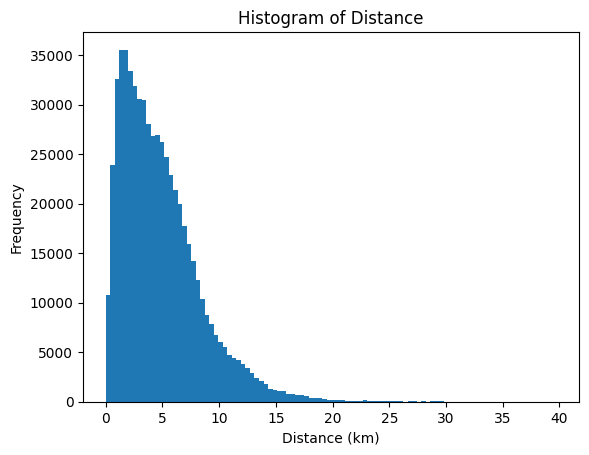

In [23]:
df['distance_h'].plot(kind='hist', bins=100)
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Histogram of Distance')
plt.show()

Since I am inspecting the distance travelled, I will also check how distance changes with time of day and day of week.

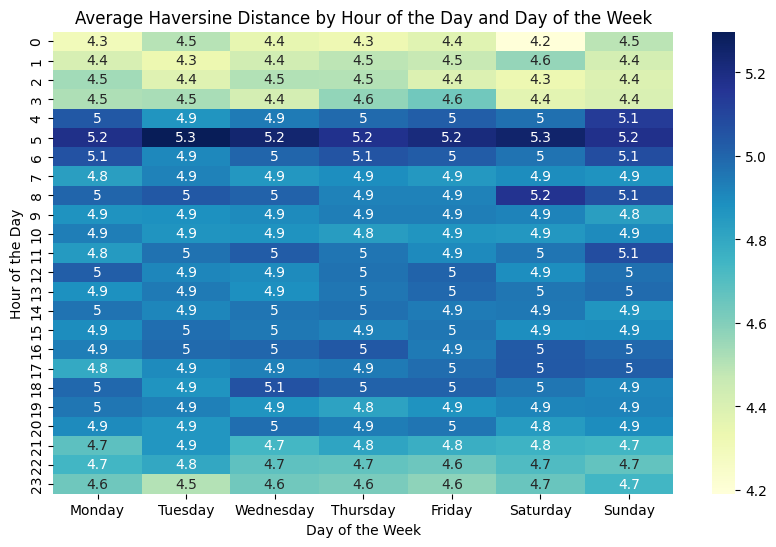

In [24]:
pivot_df = df.pivot_table(index='start_hour', columns='start_day', values='distance_h', aggfunc='mean')
pivot_df = pivot_df[days_ordered]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=True
            # , fmt='d'
            )
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.title('Average Haversine Distance by Hour of the Day and Day of the Week')
plt.show()


Night rides tend to be shorter than daytime rides.

### Ride Value

Now, let's explore `ride_value`.

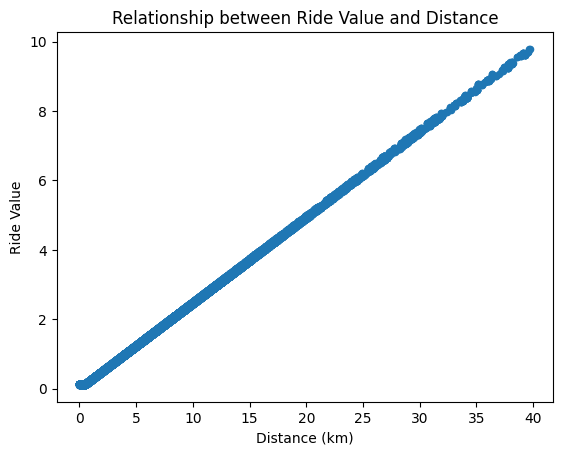

In [25]:
df.plot(x='distance_h', y='ride_value', kind='scatter')
plt.xlabel('Distance (km)')
plt.ylabel('Ride Value')
plt.title('Relationship between Ride Value and Distance')
plt.show()

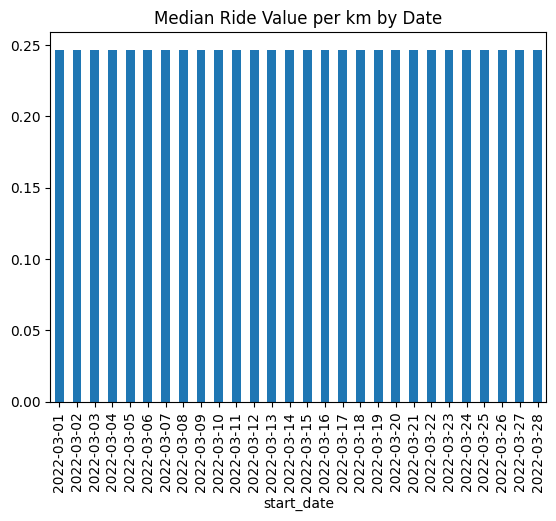

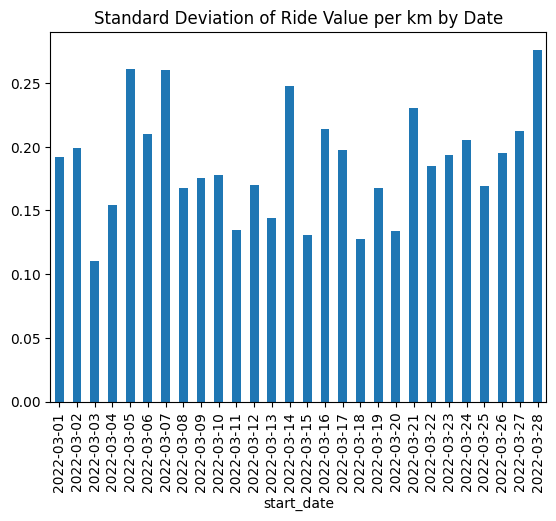

In [26]:
df['ride_value_per_km'] = df['ride_value'] / df['distance_h']

df.groupby('start_date')['ride_value_per_km'].median().plot(kind='bar', title='Median Ride Value per km by Date')
plt.show()  

df.groupby('start_date')['ride_value_per_km'].std().plot(kind='bar', title='Standard Deviation of Ride Value per km by Date')
plt.show()

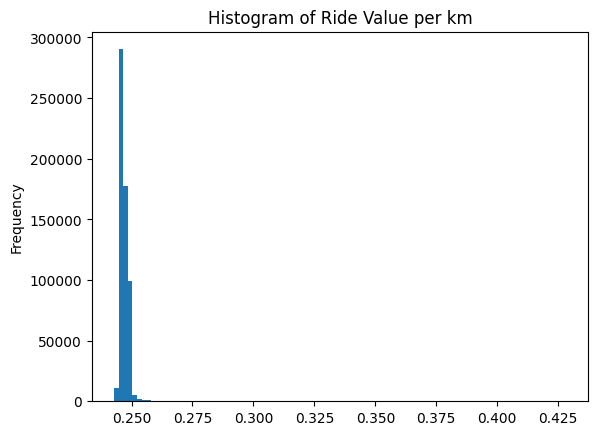

In [27]:

lower_bound = df['ride_value_per_km'].quantile(0.01)
upper_bound = df['ride_value_per_km'].quantile(0.99)

df0 = df[(df['ride_value_per_km'] >= lower_bound) & (df['ride_value_per_km'] <= upper_bound)]
df0['ride_value_per_km'].plot(kind='hist', bins=100, title = 'Histogram of Ride Value per km')
plt.show()


Ride value per km is relatively stable. Its distribution is U-shaped (bimodal). This specific shape maight be due to the fact that price per km is bounded. 
Outliers might have been caused by the imperfect distance calculation (as discussed above).

### Rides

Now, let's move to the demand for rides.

(-0.5, 27.5)


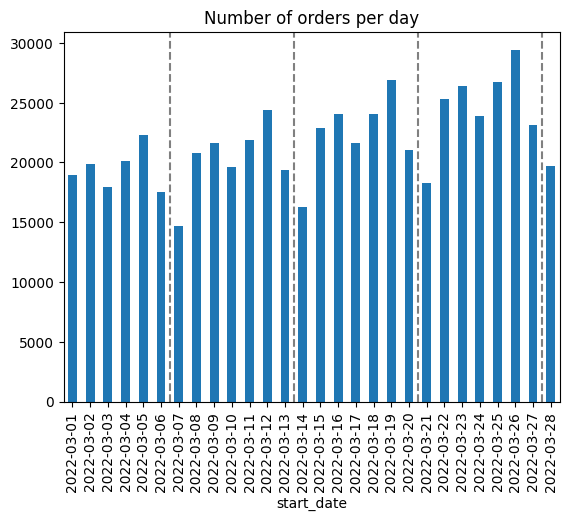

In [28]:
fig, ax = plt.subplots()

df0 = df.groupby(['start_date']).size()
df0.plot(ax=ax, kind='bar', title='Number of orders per day')
print(ax.get_xlim())

for date in df0.index:
    if date.weekday() == 0:
        ax.axvline(df0.index.get_loc(date)-0.5, color='grey', linestyle='--')

plt.show()

# Grey lines indicate the start of a new week (Monday)

Demand for rides exhibits a weekly pattern, with a peak on Saturdays and Fridays. 
On top of the weekly seasonality, there is a clear upward trend in the number of rides over time.

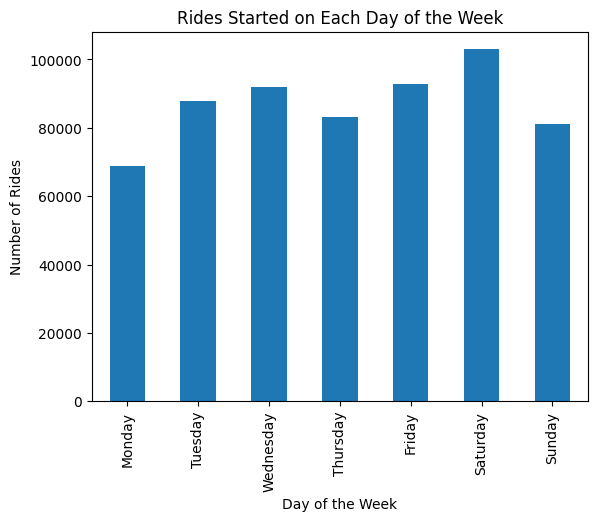

In [29]:
ride_count_by_day = df.groupby('start_day').size()
ride_count_by_day = ride_count_by_day.reindex(days_ordered)

ride_count_by_day.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.title('Rides Started on Each Day of the Week')
plt.show()


Let's check more detailed data, split by time of the day.

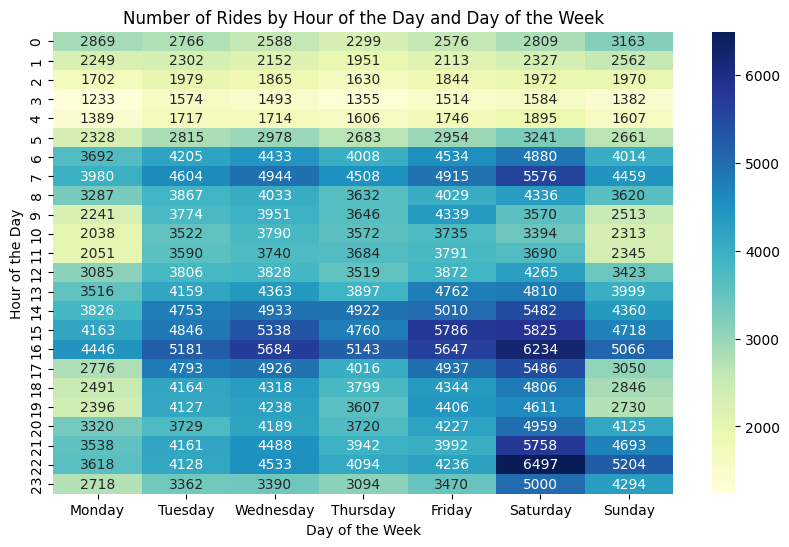

In [30]:
pivot_df = df.pivot_table(index='start_hour', columns='start_day', values='start_time', aggfunc='count')
pivot_df = pivot_df[days_ordered]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=True, fmt='d')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.title('Number of Rides by Hour of the Day and Day of the Week')
plt.show()

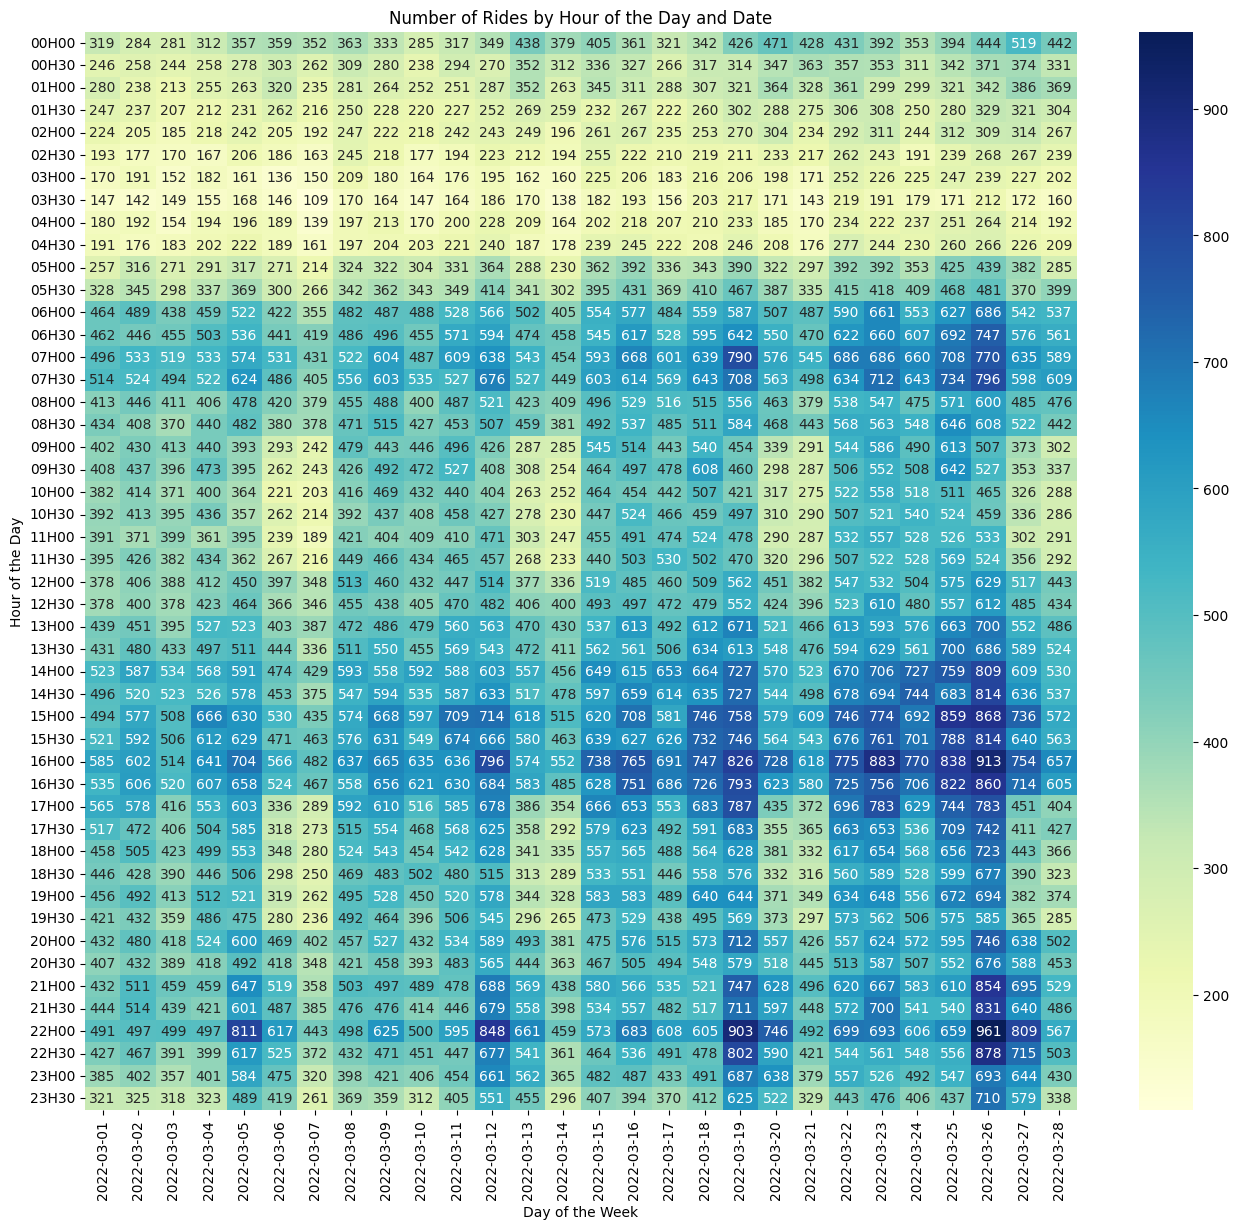

In [31]:
# Pivot the dataframe to get the count of rides for each combination of start_hour and start_day
pivot_df = df.pivot_table(index='start_unit_h', columns='start_date', values='start_time', aggfunc='count')
# pivot_df = pivot_df[days_ordered]

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=True, fmt='d')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.title('Number of Rides by Hour of the Day and Date')
plt.show()

It is clear that demand for rides depends on the time of the day and the day of the week. The heatmap shows that the demand is higher:
- on weekdays, especially during the morning and afternoon rush hours,
- on Friday and Saturday evenings/nights.
This pattern is consistent across the 4 weeks of March 2022 (with demand slightly increasing over time though).

It means that there is potential for a model to predict the number of rides for each hour of the day and day of the week.

# Location Clustering

In order to efficiently manage supply, I plan to split the geographical area of Tallinn into smaller neighborhoods.


Locations within the same neighborhood should be in close proximity to each other, where closeness is defined by the small road distance between them. 
(In this notebook, I will stick to the Haversine distance.)

Later, I will forecast the demand for rides by neighborhood, which will enable the discovery of high-demand areas. 
These insights will then be shared with the drivers, guiding them to areas where they are most likely to find customers.

I will try 2 clustering approaches:
- H3 hexagons from the h3 library by Uber,
- K-means clustering.

### Clustering - Approach 1

In [32]:
# Find H3 indexes of the start coordinates with resolution=6
df['h3_index_orig'] = df.apply(lambda row: h3.geo_to_h3(row['start_lat'], row['start_lng'], resolution=6), axis=1)

# Find centroids
h3_centers = df.groupby(['h3_index_orig']).size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)
h3_centers = h3_centers.reset_index().rename(columns={'index': 'h3_index'})
h3_centers['geo'] = h3_centers['h3_index_orig'].apply(lambda x: h3.h3_to_geo(x))
h3_centers['lat'] = h3_centers['geo'].apply(lambda x: x[0])
h3_centers['lng'] = h3_centers['geo'].apply(lambda x: x[1])

df = pd.merge(df, h3_centers[['h3_index_orig', 'h3_index', 'lat', 'lng']], on='h3_index_orig', how='left')

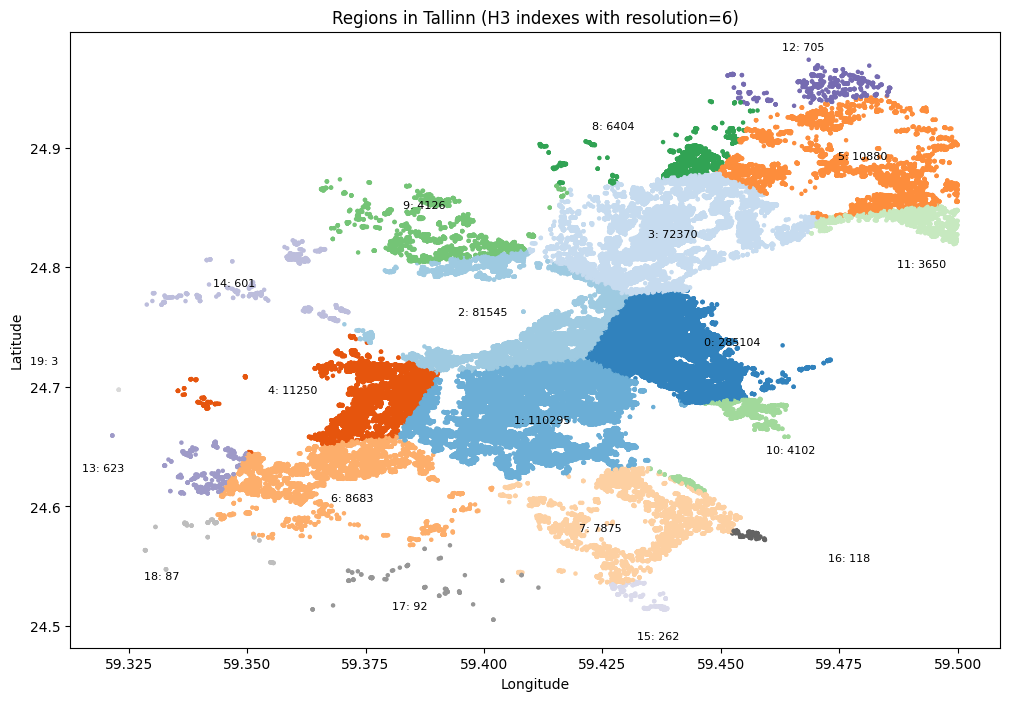

In [33]:
# Create a map of the h3 indexes

k = df['h3_index'].nunique()

fig, ax = plt.subplots(figsize=(12, 8))

df['h3_index'] = df['h3_index'].astype('category')
scatter = ax.scatter(x=df.start_lat.values, y=df.start_lng.values, c=df.h3_index.cat.codes.values, cmap='tab20c', s=5)
for i in range(k):
    h3_cent = h3_centers[h3_centers['h3_index'] == i]
    ax.text(h3_cent['lat'], h3_cent['lng'], f"{i}: {h3_cent['count'].values[0]}", color='black', fontsize=8, ha='center', va='center')
ax.set_title("Regions in Tallinn (H3 indexes with resolution=6)")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Cluster IDs are sorted by demand, with cluster 0 having the highest demand. 
The number of rides in each neighborhood is displayed on the map, along with the cluster ID.

We can observe on the map that locations have been assigned to hexagon-like neighborhoods.

Unfortunately, it's also noticeable that the clustering is not perfect. 
For instance, Cluster 2 overlaps with a water body, with the water body situated at the center of the cluster. 
As a result, Cluster 2 is "torn apart". It would be more logical for the northern part of Cluster 2 to be reassigned to Cluster 9.
(This issue would be even more significant for the supply allocation problem if we were to use the actual road distance.)

Also, for a real-life use case, the neighbourhoods are most likely too large.

Now, let's visualize demand over time by cluster (H3 index).

/var/folders/_9/csx7y18d1h72jnzdh86493jr0000gq/T/ipykernel_29596/544343845.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['start_time_int60m', 'h3_index']).size().unstack().plot(figsize=(16, 6))


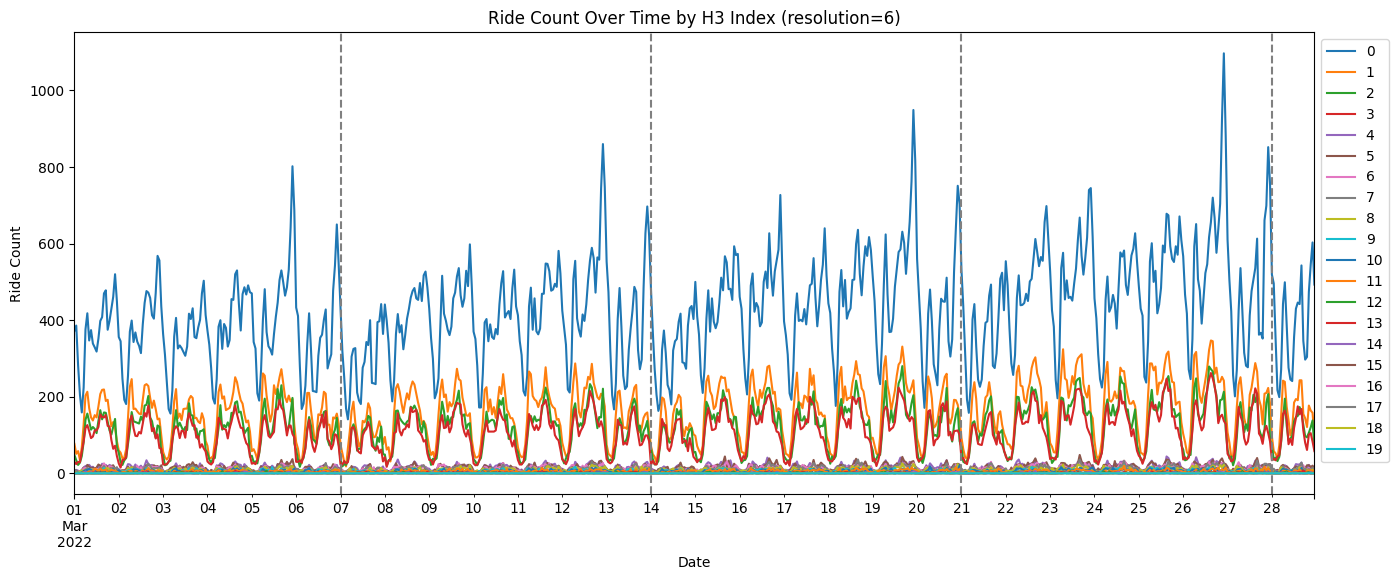

In [34]:
df.groupby(['start_time_int60m', 'h3_index']).size().unstack().plot(figsize=(16, 6))
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.title('Ride Count Over Time by H3 Index (resolution=6)')
plt.legend(bbox_to_anchor=(1, 1)) 

# Add vertical lines for Mondays
for date in df['start_time_int60m'].dt.date.unique():
    if date.weekday() == 0:
        plt.axvline(x=date, color='grey', linestyle='--')
plt.show()

The majority of demand is concentrated in a few areas - clusters 0, 1, 2, 3. These clusters are likely to represent the city center and other popular areas.

All clusters exhibit daily and weekly seasonality, with clusters 0, 1, 2, 3 displaying the highest levels of volatility.

### Clustering - Approach 2

Let's explore another clustering solution. I will use KMeans algorithm for quick clustering and flexibility in terms of number of clusters.
It is important to notice that KMeans uses Euclidean distance which again - might not yield optimal results for a real-world application.

As an alternative, one could use the DBSCAN algorithm with the Haversine or road distance.

/var/folders/_9/csx7y18d1h72jnzdh86493jr0000gq/T/ipykernel_29596/1677918810.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_centers = pd.concat([cluster_centers, cc0])


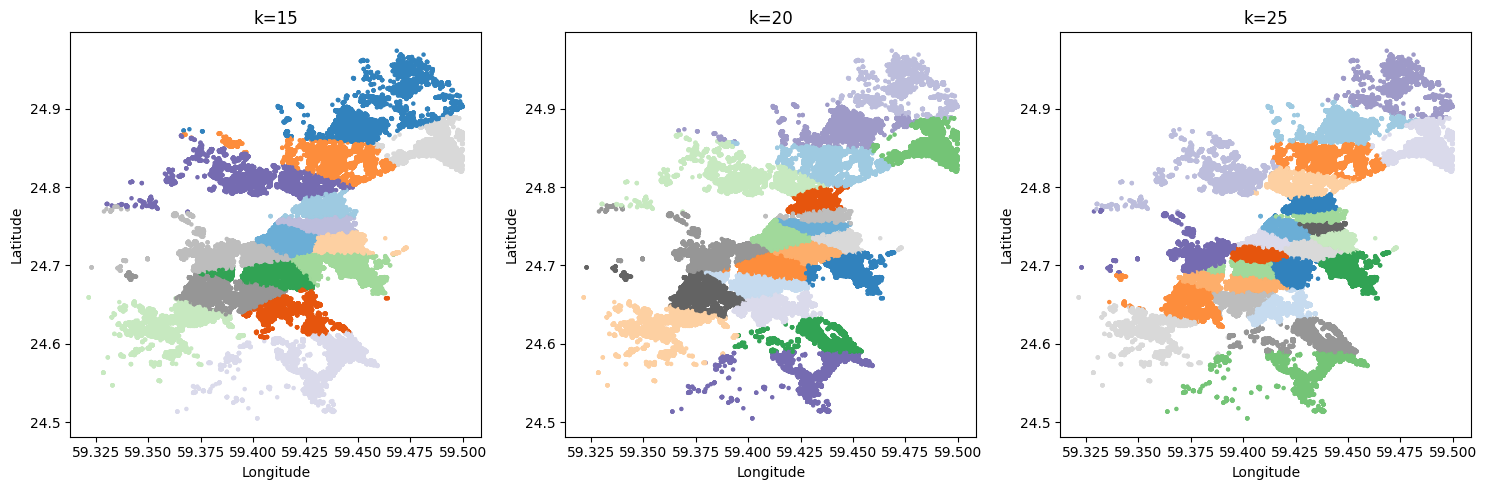

In [35]:
X = df[['start_lng', 'start_lat']].values

cluster_centers = pd.DataFrame(columns=['lng', 'lat'])
n_clusters = [15, 20, 25]
for k in n_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.labels_
    df[f'clust_{str(k).zfill(2)}'] = labels
    cc0 = pd.DataFrame(kmeans.cluster_centers_, columns=['lng', 'lat']).reset_index()
    cc0 = cc0.rename(columns={'index': 'clust'})
    cc0['k'] = f'clust_{str(k).zfill(2)}'
    cluster_centers = pd.concat([cluster_centers, cc0])

fig, ax = plt.subplots(nrows=1, ncols=len(n_clusters), figsize=(15, 5))
for i, k in enumerate(n_clusters):
    scatter = ax[i].scatter(x=df.start_lat.values, y=df.start_lng.values, c=df[f'clust_{str(k).zfill(2)}'], cmap="tab20c", s=5)
    ax[i].set_title(f"k={k}")
    ax[i].set_xlabel('Longitude')
    ax[i].set_ylabel('Latitude')
plt.tight_layout()
plt.show()


I plotted the results of three clustering attempts - with 15, 20, and 25 clusters. From a visual assessment, the clusters appear to be more suited than those generated by the H3 library with a resolution of 6.

I will proceed with 20 clusters.

In [36]:
# Reindex clusters by size

reindex_df = pd.DataFrame()
for k in [15, 20, 25]:
    reindex = df[f'clust_{str(k).zfill(2)}'].value_counts().reset_index().reset_index().rename(columns={'index': f'cluster_{str(k).zfill(2)}'})
    if f'cluster_{str(k).zfill(2)}' in df.columns:
        df.drop(columns=[f'cluster_{str(k).zfill(2)}'], inplace=True)
    df = pd.merge(df, reindex[[f'clust_{str(k).zfill(2)}', f'cluster_{str(k).zfill(2)}']], on=f'clust_{str(k).zfill(2)}', how='left')
    reindex['k'] = f'clust_{str(k).zfill(2)}'
    reindex_df = pd.concat([reindex_df, reindex.rename(columns={f'cluster_{str(k).zfill(2)}': 'cluster', f'clust_{str(k).zfill(2)}': 'clust'})])

cluster_centers = pd.merge(cluster_centers, reindex_df, left_on=['k', 'clust'], right_on=['k', 'clust'], how='left')

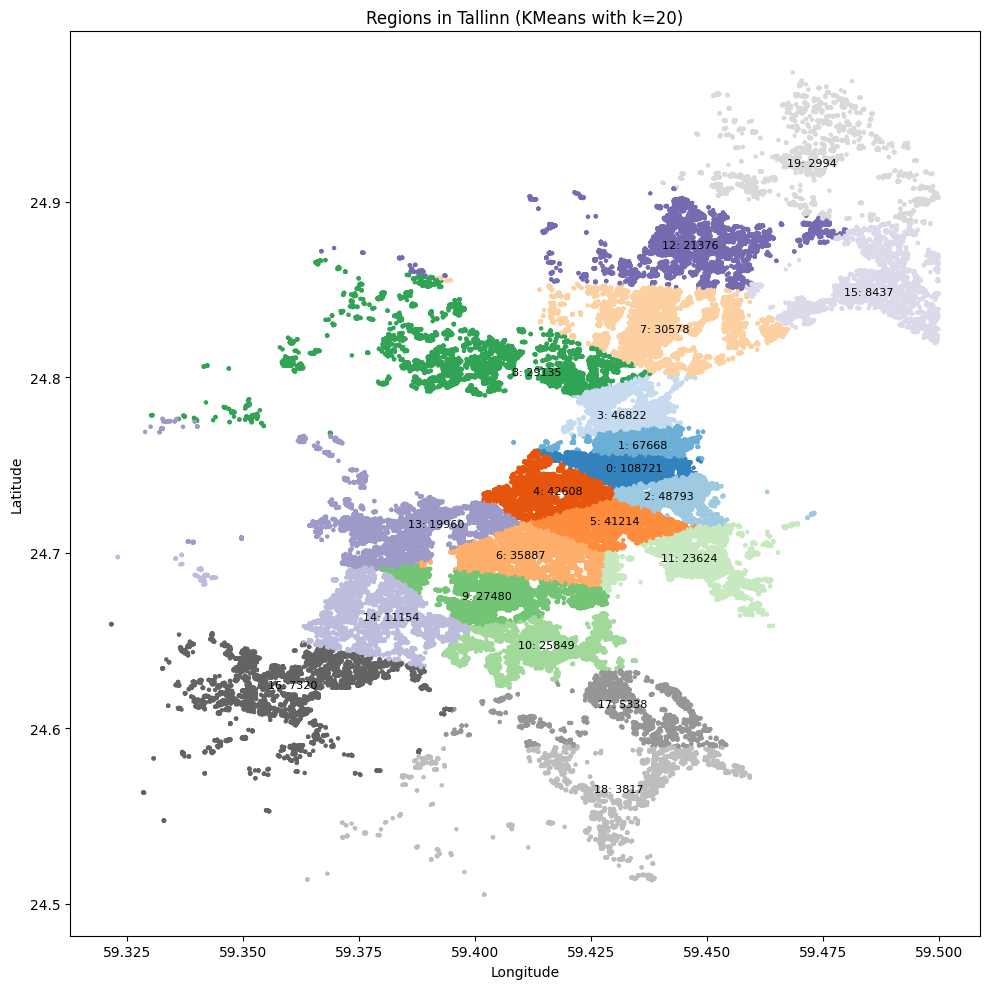

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
scatter = ax.scatter(x=df.start_lat.values, y=df.start_lng.values, c=df[f'cluster_20'], cmap="tab20c", s=5)
for i in range(20):
    cluster_center = cluster_centers[(cluster_centers['k'] == 'clust_20') & (cluster_centers['cluster'] == i)]
    ax.text(cluster_center['lat'], cluster_center['lng'], f"{i}: {cluster_center['count'].values[0]}", color='black', fontsize=8, ha='center', va='center')
ax.set_title("Regions in Tallinn (KMeans with k=20)")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

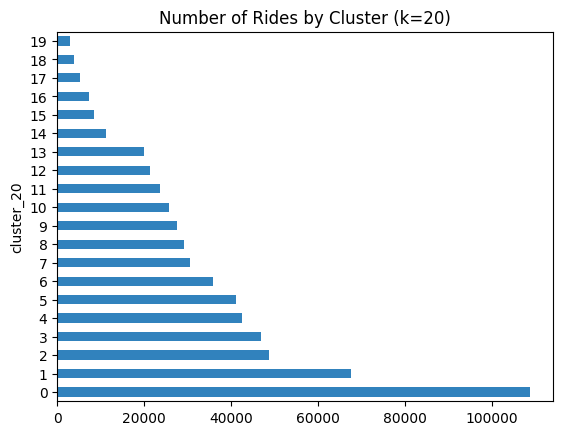

In [38]:
df.groupby('cluster_20').size().plot(kind='barh', cmap='tab20c', title='Number of Rides by Cluster (k=20)')   
plt.show() 

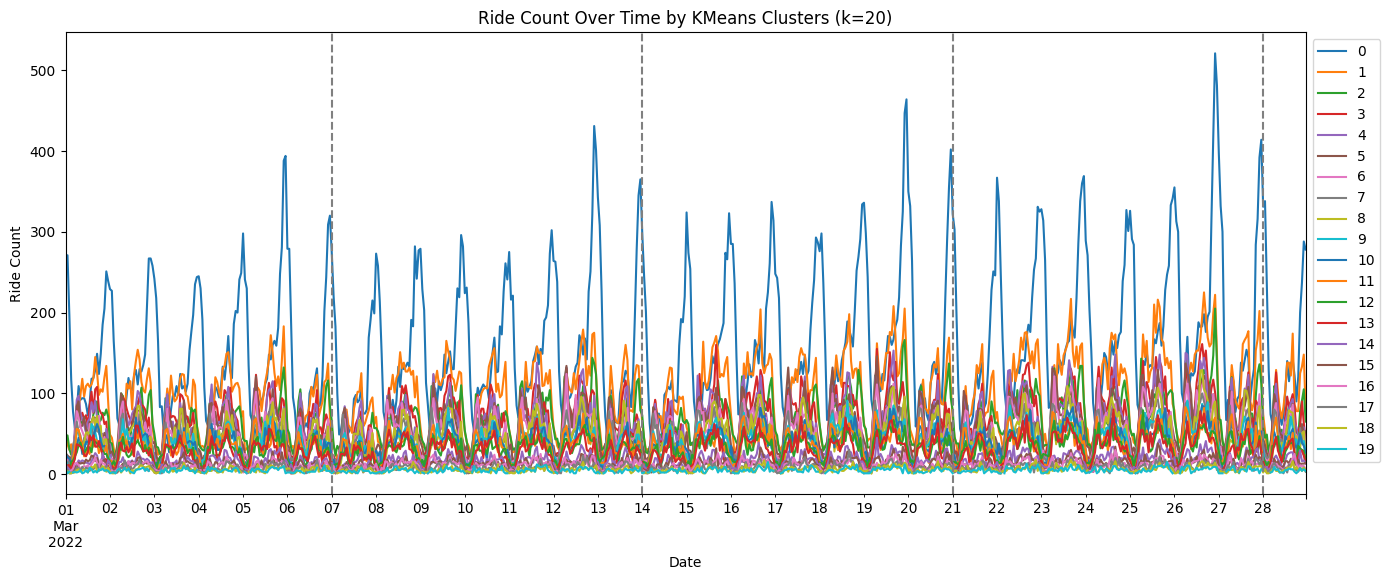

In [39]:
df.groupby(['start_time_int60m', 'cluster_20']).size().unstack().plot(figsize=(16, 6))
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.title('Ride Count Over Time by KMeans Clusters (k=20)')
plt.legend(bbox_to_anchor=(1, 1))
# Add vertical lines for Mondays
for date in df['start_time_int60m'].dt.date.unique():
    if date.weekday() == 0:
        plt.axvline(x=date, color='grey', linestyle='--')
plt.show()


It is clear that as before, the number of rides follows daily and weekly patterns.
However, in contrast to the previous clustering, the KMeans clustering has created more evenly distributed clusters.

# Demand Forecasting

### Splitting Data into Train and Test Sets

When working with time series data, it is important to split data into train and test sets based on time. 
Training data must come from time prior to test data.

Another important aspect, especially for the training data, is related to seasonality - including full seasonal cycles. 

I will use the the first 3 weeks of the available data for training and leave the last week of data for testing.

In [40]:
test_start = pd.to_datetime('2022-03-22')
test_end = pd.to_datetime('2022-03-29')
df['set'] = df['start_time'].apply(lambda x: 'train' if x < test_start else 'test')

### Model 0 (Prophet), H3 clusters

I do not have much time left for this assignment, hence model training and testing part will be limited to a very basic approach.

I will use `phophet` library for easy, almost out-of-the box forecasting. It does not require a lot of hyperparameter tuning, takes care of the trend, and deals very well with seasonal effects.


However, before proceeding with forecasting, I need to explain how the granularity of the data affects the testing strategy.

For efficient supply management, the demand forecast must be accurate, requiring precision both location-wise and time-wise. The window for a single forecast cannot be too wide, as it would not allow for prompt enough reactions to changes in demand. Hence, the forecast will be made for the next time interval only (`t`). In this case, the time interval is 1 hour. 

To forecast demand for the following time interval (`t+1`), one can use data with an additional time interval (a rolling forecast strategy) to train a new model.



I will prepare code for the strategy mentioned above and run basic predictions.


In [41]:
def forecast_prophet(df, time_interval_col, clusters_col, forecast_start, forecast_end, forecast_granularity='D'):
    clusters = df[clusters_col].unique()
    predictions = pd.DataFrame()
    predictions_all = pd.DataFrame()
    for cluster in clusters:
        df0 = df[(df[clusters_col] == cluster)].groupby(time_interval_col).size().reset_index(name='y')
        df0 = df0.rename(columns={time_interval_col: 'ds'})
        df0['ds'] = pd.to_datetime(df0['ds'])
        
        current_time = forecast_start
        while current_time <= forecast_end:
            # Train the model on data up to the current time
            model = Prophet()
            model.fit(df0[df0['ds'] < current_time])
            
            # Make a prediction for the next period
            future = pd.DataFrame([current_time], columns=['ds'])
            forecast = model.predict(future)

            # Store the prediction
            predictions = pd.concat([predictions, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]], ignore_index=True)
            predictions[clusters_col] = cluster

            predictions_all = pd.concat([predictions_all, predictions], ignore_index=True)
    
            # Move to the next period
            if forecast_granularity == 'D':
                current_time += pd.Timedelta(days=1)
            elif forecast_granularity == 'H':
                current_time += pd.Timedelta(hours=1)
    
    ytrue = df.groupby([clusters_col, time_interval_col]).size().reset_index(name='y_true')
    ytrue[time_interval_col] = pd.to_datetime(ytrue[time_interval_col])
    predictions_all = pd.merge(predictions_all, ytrue, left_on=['ds', clusters_col], right_on=[time_interval_col, clusters_col], how='left')
    
    return predictions_all

In [ ]:
pred_prophet_h3_d = forecast_prophet(df, 'start_date', 'h3_index', forecast_start=test_start, forecast_end=test_end, forecast_granularity='D') # daily granularity

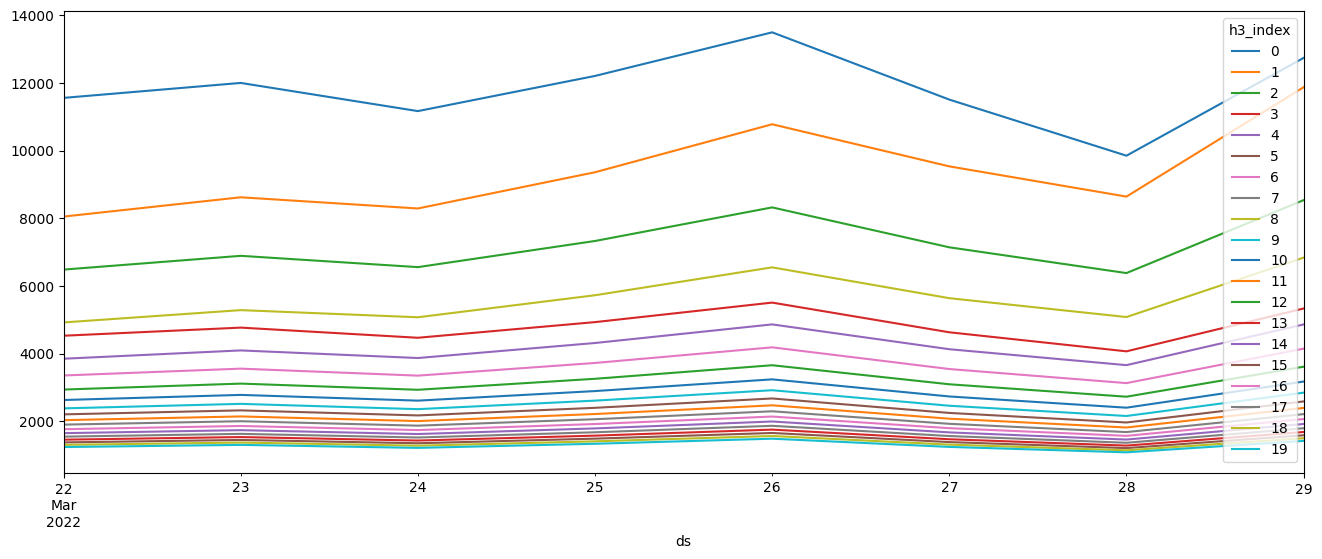

In [43]:
pred_prophet_h3_d.pivot_table(index='ds', columns='h3_index', values='yhat').plot(figsize=(16, 6))
plt.show()

In [ ]:
pred_prophet_h3_h = forecast_prophet(df, 'start_hour', 'h3_index', forecast_start=test_start, forecast_end=test_end, forecast_granularity='H') # hourly granularity

In [45]:
pred_prophet_h3_h.pivot_table(index='ds', columns='h3_index', values='yhat').plot(figsize=(16, 6))
plt.show()

NameError: name 'pred_prophet_h3_h' is not defined

There are problems with the prophet model with hourly frequency, hence I will quickly try another solution.

### Model 1 (ARIMA), KMeans clusters

I will quickly try to use ARIMA. I will select a set of parameters based on the biggest cluster (Cluster 0) and re-use those parameters for other clusters. 
(In real-life, each parameter selection must happen for every cluster separately.)

I will decide upon the following parameters:
p - the number of autoregressive terms,
d - the number of differences,
q - the number of moving average terms.

In [46]:
df0 = df[(df['cluster_20'] == 0)].groupby('start_time_int60m').size().reset_index(name='y').set_index('start_time_int60m')

In [47]:
# Augmented Dickey-Fuller test for stationarity
result = adfuller(df0)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.233569
p-value: 0.018122
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


With alpha=0.05, there is not enough evidence to reject the null hypothesis (=> the series would be treated as stationary). 

With alpha=0.01, the null hypothesis would be rejected (=> non-stationary series).



Now, I will check first- and second-order differences to decide about the `d` parameter.

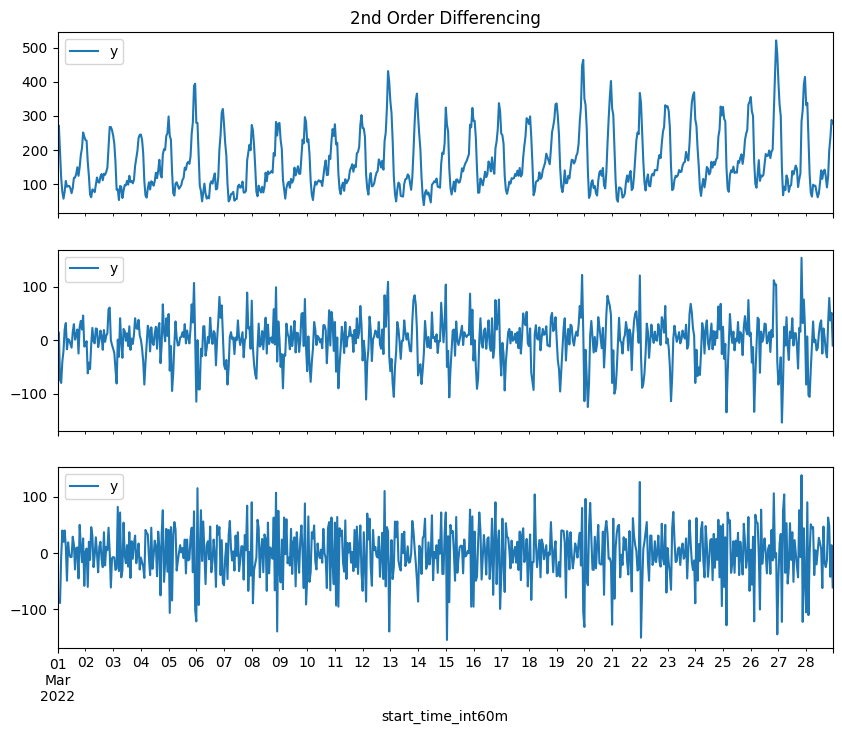

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))

df0.plot(ax=ax1)    
ax1.set_title('Original Series')

df0.diff().plot(ax=ax2)    
ax1.set_title('1st Order Differencing')

df0.diff().diff().plot(ax=ax3)    
ax1.set_title('2nd Order Differencing')

plt.show()

As the ADF test suggested, there does not seem to be absolute need for differencing. I will use the first order differences though (also because the params will be shared across clusters).

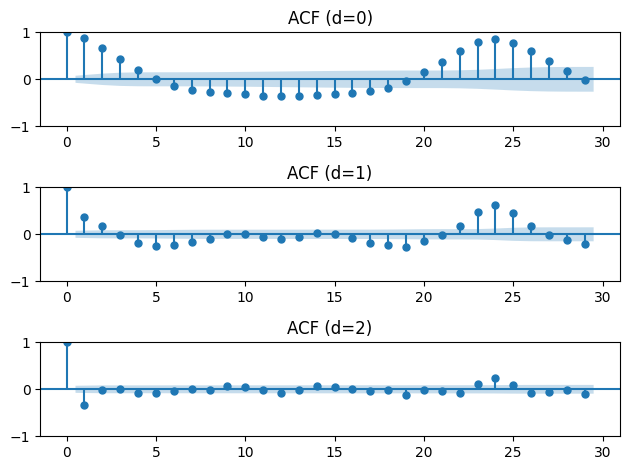

In [49]:

fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df0, ax=ax1, title='ACF (d=0)')
plot_acf(df0.diff().dropna(), ax=ax2, title='ACF (d=1)')
plot_acf(df0.diff().diff().dropna(), ax=ax3, title='ACF (d=2)')
plt.tight_layout()
plt.show()

The autocorrelation plot also suggests d=1.

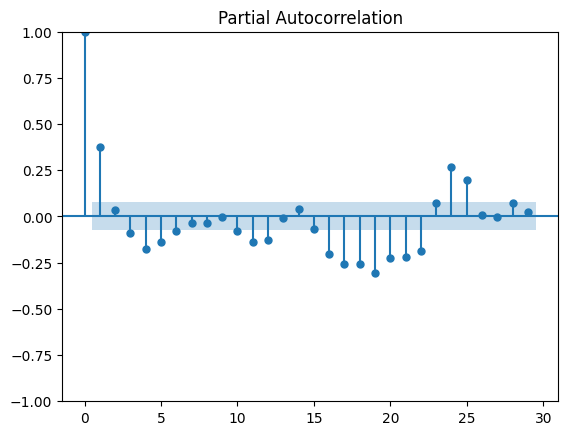

In [50]:

plot_pacf(df0.diff().dropna())

The partial autocorrelation plot suggest p=2 or p=1.

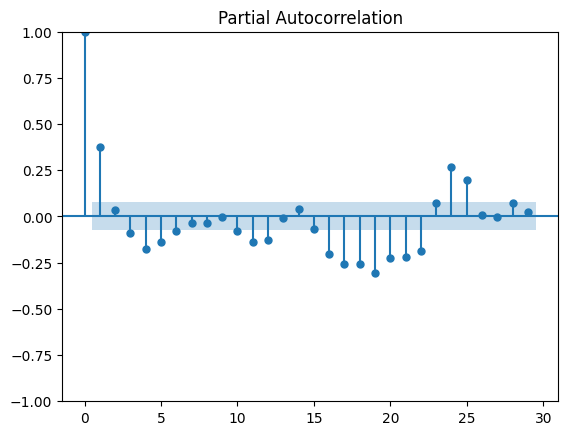

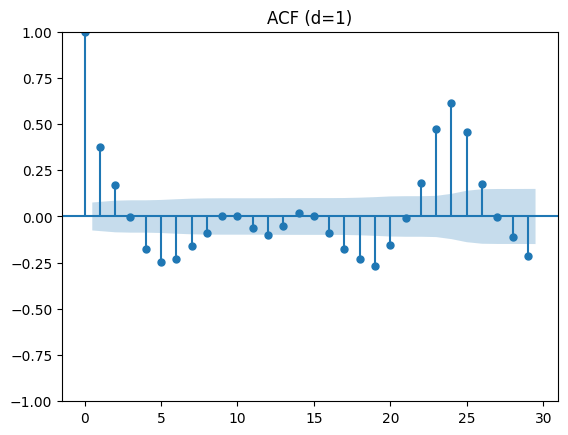

In [51]:

plot_acf(df0.diff().dropna(), title='ACF (d=1)')
plt.show()

Optimal q is equal to 2.

In [ ]:
# ARIMA(1, 1, 2)

predictions_all = pd.DataFrame()
clusters = clusters = range(0, 16)
for cluster in clusters:
    print(cluster)
    df0 = df[(df['cluster_20'] == cluster)].groupby('start_time_int60m').size().reset_index(name='y_true').set_index('start_time_int60m')
    model = ARIMA(df0, order=(1, 1, 2))
    model_fit = model.fit()

    predictions = model_fit.predict(start=test_start, end=test_end)
    predictions = predictions.reset_index()
    predictions['cluster'] = cluster
    predictions.columns = ['ds', 'y_pred', 'cluster']
    predictions = pd.merge(predictions, df0, left_on='ds', right_index=True, how='left')

    predictions_all = pd.concat([predictions_all, predictions], ignore_index=True, axis=0)


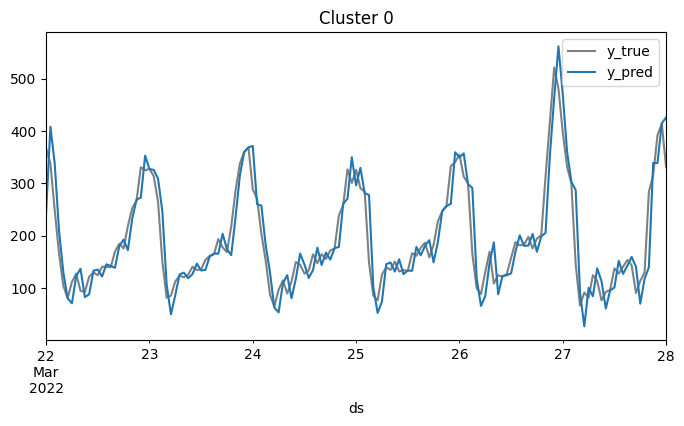

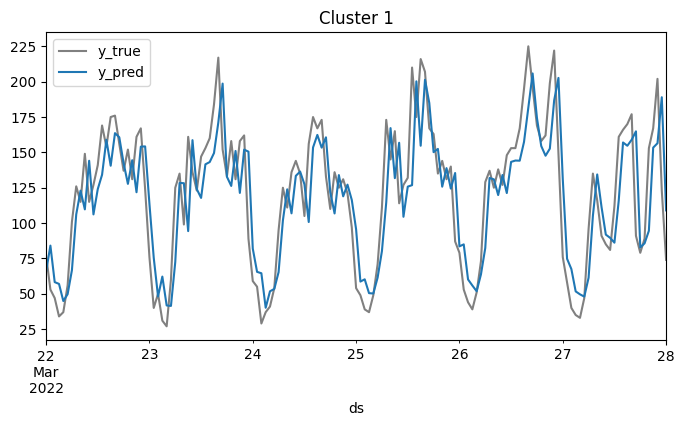

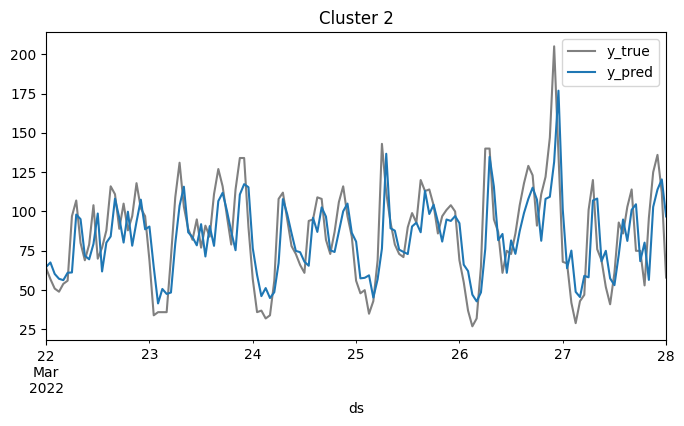

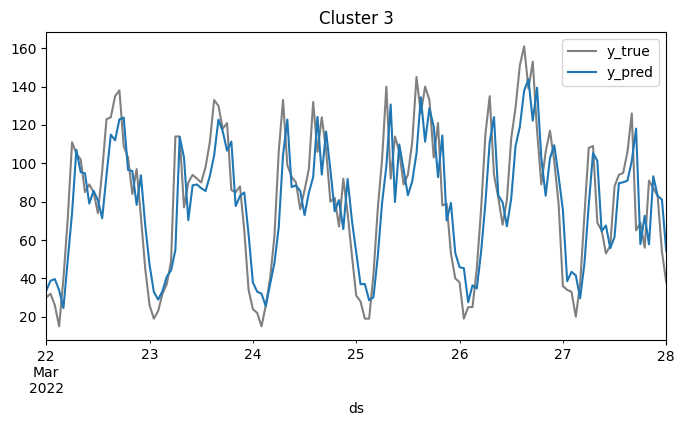

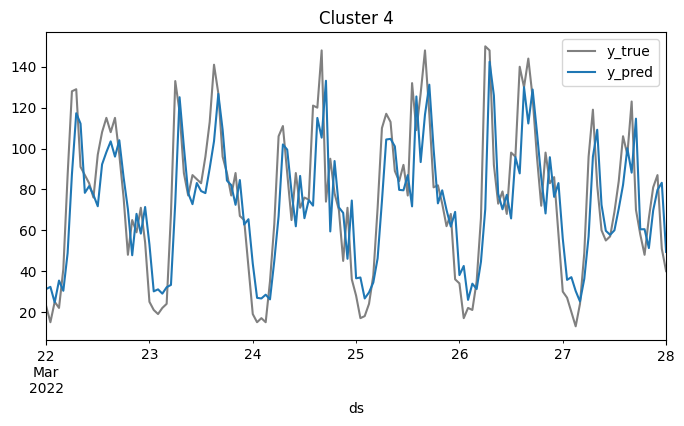

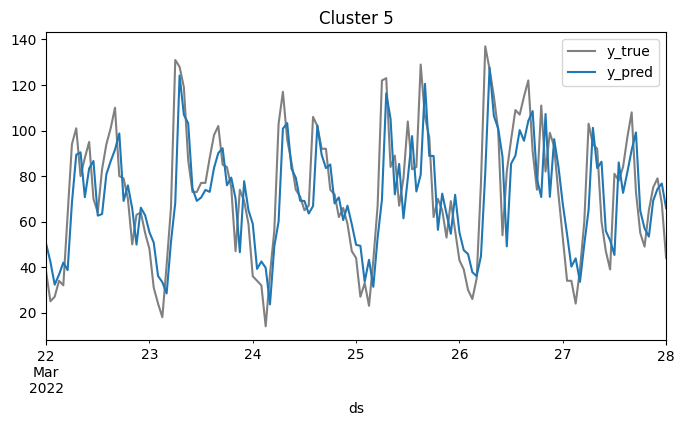

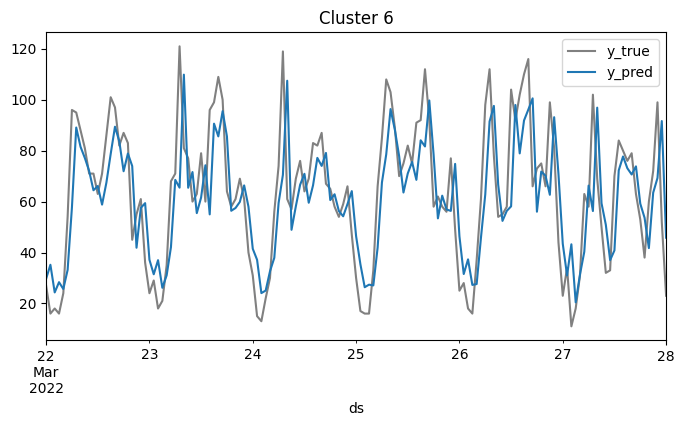

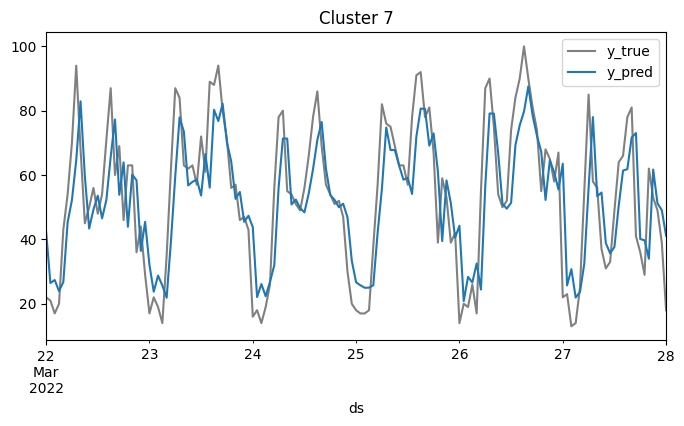

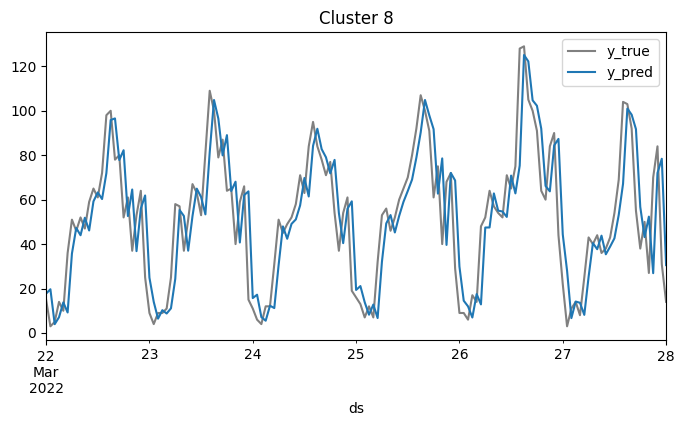

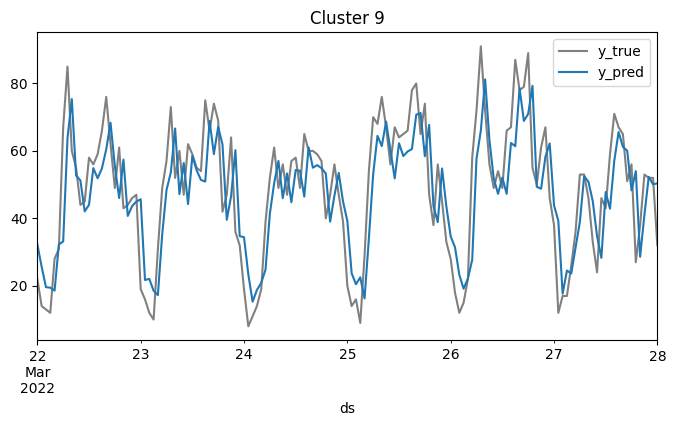

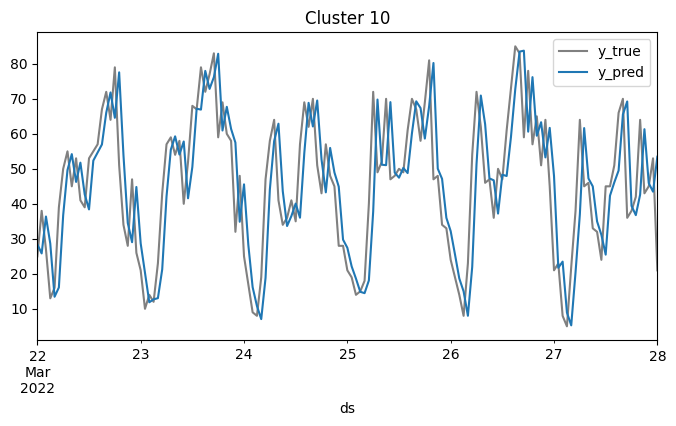

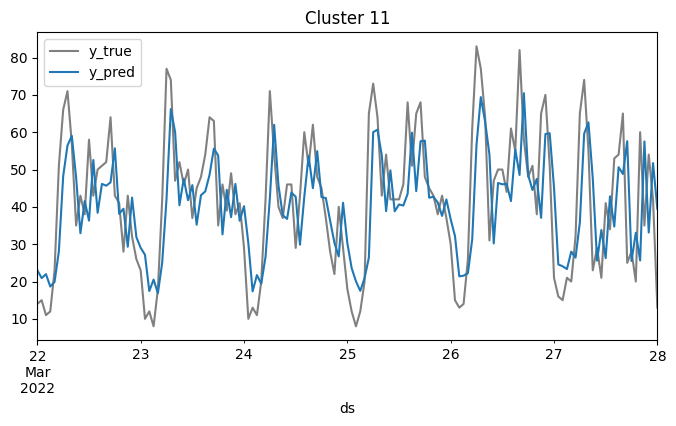

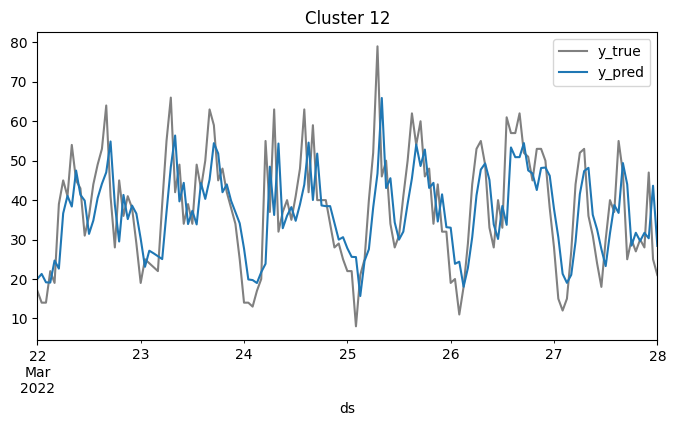

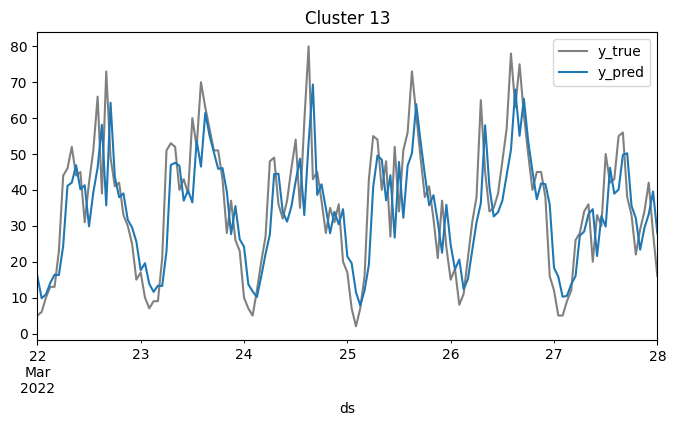

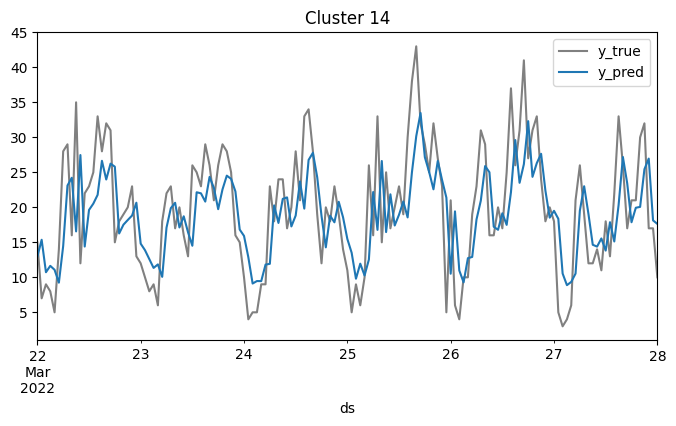

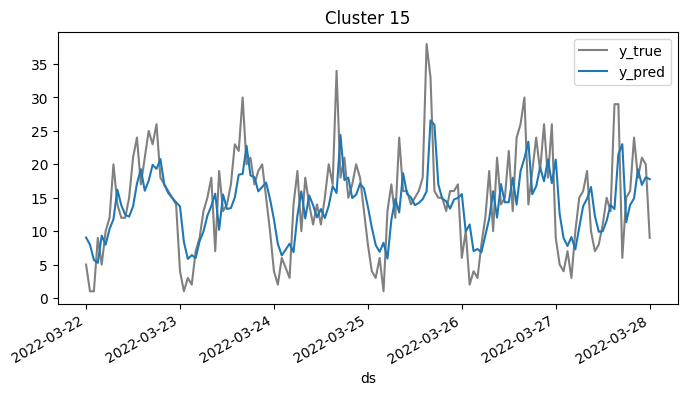

In [58]:

for cluster in range(0, 16):
    predictions_all[predictions_all['cluster'] == cluster].plot(x='ds', y=['y_true', 'y_pred'], title=f'Cluster {cluster}', figsize=(8, 4), color=['grey', 'C0'])
    plt.show()

We can see that the model is not perfect when it comes to predicting the number of rides but it does capture the patterns observed in the data. 

I will use this ARIMA(1, 1, 2) model as my baseline model.

### Model Evaluation

How to evaluate such predictions? My suggestions would be:
- Select the evaluation metric, for instance, RMSE (Root Mean Square Error), which penalizes larger errors more than MAE (Mean Absolute Error). 
- When selecting a metric, one can also consider a non-symmetric metric - the usage of such a metric would be justified if the company cared more about either the demand side (short waiting times) or the supply side.
- Calculate the metric for each cluster.
- Aggregate the error by taking a combination of the cluster errors (weighted average where weights are proportional to the typical demand size).
- Repeat the same steps for another model and compare the aggregated errors. 

In [59]:

grouped_predictions = predictions_all.groupby('cluster')

# RMSE for each cluster
rmse_by_cluster = {}
for cluster, group in grouped_predictions:
    true_values = group['y_true']
    predicted_values = group['y_pred']
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    rmse_by_cluster[cluster] = rmse

for cluster, rmse in rmse_by_cluster.items():
    print(f"Cluster {cluster}: RMSE = {rmse}")


Cluster 0: RMSE = 42.71883793680303
Cluster 1: RMSE = 28.706037610115846
Cluster 2: RMSE = 20.840987803196803
Cluster 3: RMSE = 20.337717640171125
Cluster 4: RMSE = 22.092400877631736
Cluster 5: RMSE = 18.219313692045457
Cluster 6: RMSE = 18.370128651874687
Cluster 7: RMSE = 14.351506189459469
Cluster 8: RMSE = 17.874294681421574
Cluster 9: RMSE = 12.444887828206722
Cluster 10: RMSE = 13.892917321767703
Cluster 11: RMSE = 13.912705663095656
Cluster 12: RMSE = 10.658689210998418
Cluster 13: RMSE = 11.616293371828924
Cluster 14: RMSE = 6.986957922500803
Cluster 15: RMSE = 5.971049381059019


In [60]:
# Define the weights for each cluster
weights = df[df['start_time']<test_start].groupby('cluster_20').size().values[0:16]

# Convert rmse_by_cluster to an array
rmse_array = np.array(list(rmse_by_cluster.values()))

# Weighted RMSE
weighted_rmse = np.sqrt(np.sum(rmse_array ** 2 * weights))
print(f"Weighted RMSE = {weighted_rmse}")


Weighted RMSE = 16382.356099288727


# Next Steps

### Other Models

As next steps, I would suggest trying the following models:
- Another, adjusted **ARIMA** model.
- A **tree-based model** or a **boosted tree-based model**, potentially **with a linear model in the leaves instead of a simple constant approximation**. Such models are known to perform well in forecasting tasks. It's important to remember that when using tree-like models for forecasting and creating features, one must pay attention to the train-test data split to ensure observations are not mixed time-wise.

### Model Deployment

In order to deploy the solution, I would:
- Move the model and its all modules to a dedicated Python script and containerize it.
- Set up data pipelines to fetch the data from the source, clean it and aggregate, prepare it for the model. The pipeline could be set up using, for example, Apache Airflow.
- Set up the batch job, using, for example, AWS Batch module. Batch processing could be scheduled with Apache Airflow again. Fitting and prediction steps should run every 30 or 60 minutes.
- Save all models to a model registry like MLflow. The registry could later be used to track the performance of the models and to compare them.
- Communicate with drivers through a dedicated API. The API could be used to send the predictions to the drivers and to receive data about the rides.
- Monitor the performance of the models and the API. The performance could be monitored using Grafana (API) and Evidently AI (model).


# Experiment

In order to test the usefulness of the described approach in practice, I suggest running an **A/B test**. The test would be conducted as follows:
- Randomly assign drivers to two groups:
    - One group (*control*) will have the same information as today.
    - The other group (*alternative*) will be informed about the expected demand and will be allowed to make a decision whether to work or not based on those suggestions. Communication with the drivers would happen through notifications in the ride-hailing app.
- Evaluation metrics:
    - The primary metric would be the number of rides completed by the drivers in each group.
    - Secondary metrics could include the average time to accept a ride, driver's satisfaction. Then - the average distance of the rides, and the average ride value.
- The test would be conducted over a period, e.g., a week.
- The results would be evaluated using a t-test to check if the difference in the primary metric is statistically significant.
- If the test is successful, the alternative approach could be implemented for all drivers.
- The test could be repeated in different cities to check if the results are consistent across locations.

**However**, before running the test, it would be necessary to consider if the effects of introducing the demand forecast would *not spill over* to the control group, since both experiment groups operate in the same geographical area and offer services to the same pool of riders. If that were the case, another approach to validation would have to be taken.